In [3]:
import pandas as pd
import numpy as np
import sys

sys.path.insert(0, '../visualize/')
sys.path.insert(0, '../models/')
sys.path.insert(0, '../features/')

from tcors_functions import *
from build_features import *
from counterprop import *
from linear_regression import *
from visualize import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score

random_state = 42

bin_step = 0.1

Prepare Data

In [4]:
build_features(step = bin_step)

In [5]:
df = load_features('model_features.pkl')
df.head()

,screen_id,week,project,site,dose,screen_sex,screen_age,carmine_nicotine,prp_change,prp_change_bin,prp_change_bin_label
37,J-A003,week12,project 1,uvm,15.8,Female,32,16.7,0.487500,"(0.4, 0.5]",4
50,J-A004,week12,project 1,uvm,0.4,Female,38,15.9,0.725225,"(0.7, 0.8]",7
76,J-A007,week12,project 1,uvm,15.8,Female,44,16.2,0.971223,"(0.9, 1.0]",9
89,J-A010,week12,project 1,uvm,15.8,Female,28,15.8,0.895522,"(0.8, 0.9]",8
117,J-A015,week12,project 1,uvm,15.8,Female,25,16.9,1.315152,"(1.3, 1.4]",13


In [21]:
df.dtypes

screen_id                 object
week                      object
project                   object
site                      object
dose                     float64
screen_sex                object
screen_age                 int64
carmine_nicotine         float64
prp_change               float64
prp_change_bin          category
prp_change_bin_label        int8
dtype: object

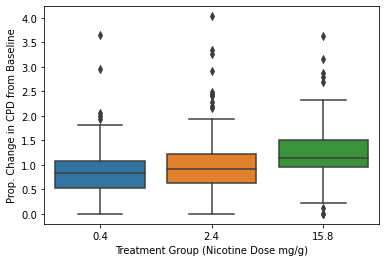

In [22]:
sns.boxplot(
    data = df,
    x = 'dose',
    y = 'prp_change'
)
plt.ylabel("Prop. Change in CPD from Baseline")
plt.xlabel("Treatment Group (Nicotine Dose mg/g)")

plt.savefig("../../reports/figures/prp_change_box.png", dpi = 400, bbox_inches = 'tight')

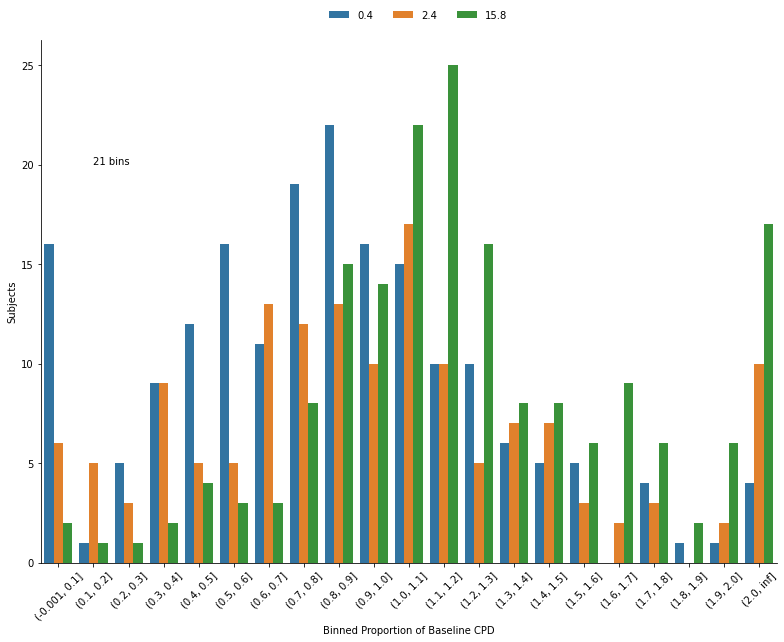

In [23]:

plot_bins(df)
# plt.tight_layout()
plt.savefig("../../reports/figures/prp_change.png", dpi = 400, bbox_inches='tight')

In [6]:
cat_targets = ['prp_change_bin_label']
num_targets = ['prp_change']
# cat_predictors = ['project', 'site', 'dose', 'screen_sex']
num_predictors = ['screen_age', 'dose', 'project_num', 'sex_num', 'site_num', 'carmine_nicotine']
num_predictors_withoutnic = num_predictors[:]
num_predictors_withoutnic.remove('carmine_nicotine')

  # create numeric versions of categorical variables
df['project_num'] = df['project'].astype('category').cat.codes
df['site_num'] = df['site'].astype('category').cat.codes
df['sex_num'] = df['screen_sex'].astype('category').cat.codes

def preprocessing(df, num_predictors, random_state):
  
    X = df[num_predictors]
    y = df[cat_targets + num_targets]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    scaler = MinMaxScaler()
    scaler.fit(X_train[num_predictors])

    X_train[num_predictors] = scaler.transform(X_train[num_predictors])
    X_test[num_predictors] = scaler.transform(X_test[num_predictors])

    X_train_without_nic = X_train.copy()
    X_test_without_nic = X_test.copy()

    X_train_without_nic.drop(['carmine_nicotine'], axis=1, inplace=True)
    X_test_without_nic.drop(['carmine_nicotine'], axis=1, inplace=True)

    return X_train, X_test, X_train_without_nic, X_test_without_nic, y_train, y_test

X_train, X_test, X_train_without_nic, X_test_without_nic, y_train, y_test = preprocessing(
  df, num_predictors, random_state
  )

   

In [25]:
X_train_without_nic

,screen_age,dose,project_num,sex_num,site_num
6009,0.36,1.00000,1.0,0.0,1.0
6137,0.76,0.12987,1.0,1.0,0.0
3371,0.20,0.12987,0.5,0.0,1.0
5191,0.08,0.00000,1.0,1.0,1.0
8731,0.68,0.12987,0.5,1.0,0.5
...,...,...,...,...,...
2200,0.24,0.12987,0.5,1.0,1.0
5165,0.58,0.12987,1.0,0.0,1.0
6455,0.74,0.00000,1.0,1.0,0.0
7883,0.40,1.00000,0.0,0.0,0.5


In [26]:
y_train['prp_change']

6009    1.791045
6137    0.623762
3371    0.913043
5191    0.367213
8731    2.920000
          ...   
2200    0.586207
5165    0.652273
6455    1.065217
7883    0.436137
2146    0.828571
Name: prp_change, Length: 410, dtype: float64

## Linear Regression

In [27]:
without_nic = fit_linear(
    X_train_without_nic,
    X_test_without_nic,
    y_train[['prp_change']],
    y_test[['prp_change']],
    bin_step = bin_step,
    random_state=random_state
)

with_nic = fit_linear(
    X_train,
    X_test,
    y_train[['prp_change']],
    y_test[['prp_change']],
    bin_step = bin_step,
    random_state=random_state
)

Performance when treated as a regression

In [28]:
wo_nic_avg = without_nic.avg_scores
wo_nic_avg['label'] = 'without_nic'

w_nic_avg = with_nic.avg_scores
w_nic_avg['label'] = 'with_nic'

lm_r2 = pd.concat([wo_nic_avg, w_nic_avg])
lm_r2['model'] = 'linear_model'

lm_r2

,mean_cv_r2,sd_cv_r2,test_r2,label,model
1,0.083358,0.075021,0.139511,without_nic,linear_model
1,0.074846,0.075885,0.092326,with_nic,linear_model


In [29]:
import statsmodels.api as sma

X1 = sma.add_constant(X_train_without_nic)
X2 = sma.add_constant(X_train)

wo_nic_sm = sma.OLS(y_train[['prp_change']], X1).fit()
w_nic_sm = sma.OLS(y_train[['prp_change']], X2).fit()

In [30]:
wo_nic_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             prp_change   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     10.87
Date:                Mon, 05 Dec 2022   Prob (F-statistic):           7.92e-10
Time:                        15:11:57   Log-Likelihood:                -346.04
No. Observations:                 410   AIC:                             704.1
Df Residuals:                     404   BIC:                             728.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.6653      0.109      6.098      0.000       0.451       0.880
screen_age      0.5823      0.141      4.139      0.000       0.306       0.859
dose            0.3615      0.063      5.715      0.000       0.237       0.486
project_num    -0.0040      0.076     -0.053      0.958      -0.154       0.146
sex_num         0.0266      0.066      0.404      0.687      -0.103       0.156
site_num        0.0191      0.087      0.219      0.827      -0.152       0.190
==============================================================================
Omnibus:                      132.923   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              493.993
Skew:                           1.419   Prob(JB):                    5.38e-108
Kurtosis:                       7.567   Cond. No.                         9.23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
w_nic_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             prp_change   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     9.837
Date:                Mon, 05 Dec 2022   Prob (F-statistic):           3.94e-10
Time:                        15:11:57   Log-Likelihood:                -343.90
No. Observations:                 410   AIC:                             701.8
Df Residuals:                     403   BIC:                             729.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.5095      0.132      3.845      0.000       0.249       0.770
screen_age           0.5856      0.140      4.179      0.000       0.310       0.861
dose                 0.3658      0.063      5.803      0.000       0.242       0.490
project_num         -0.0016      0.076     -0.021      0.983      -0.151       0.147
sex_num              0.0349      0.066      0.531      0.596      -0.094       0.164
site_num             0.0443      0.088      0.506      0.613      -0.128       0.217
carmine_nicotine     0.4791      0.233      2.056      0.040       0.021       0.937
==============================================================================
Omnibus:                      121.348   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              400.639
Skew:                           1.332   Prob(JB):                     1.01e-87
Kurtosis:                       7.045   Cond. No.                         13.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Performance when treated as a classifier

In [32]:
lm_f1 = pd.DataFrame(
    {
        "f1" : [without_nic.clf_mets, with_nic.clf_mets],
        "label" : ["without_nic", "with_nic"],
        "model" : ['linear_model*', 'linear_model*']
    }
)
lm_f1


,f1,label,model
0,0.106796,without_nic,linear_model*
1,0.116505,with_nic,linear_model*


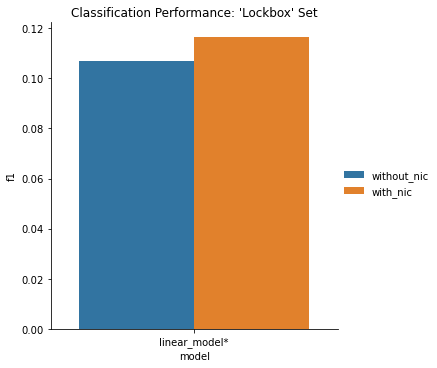

In [33]:
clf_plt(lm_f1)
plt.savefig(fname = "../../reports/figures/clf_perf_onemtd.png", dpi = 300, bbox_inches='tight')

## Counter-Propagation  

Cross Validation    

In [34]:
def counterprp_fit_predict(
        X_train: np.array, X_test: np.array, 
        y_train_onehot: np.array, y_test_onehot: np.array, 
        y_test_labels: pd.Series, random_init=False,
        epochs=25):

    mod = train_model(
        X_train, 
        y_train_onehot,
        random_init=random_init, 
        n_hidden = len(X_train), 
        epochs=25
        )
    pred1 = predict_model(np.array(X_test), y_test_onehot, mod.pass1_weights)
    pred2 = predict_model(np.array(X_test), y_test_onehot, mod.pass2_weights)   

    f1_pred1 = f1_score(y_test_labels, pred1.predict_cat, average = 'micro')
    f1_pred2 = f1_score(y_test_labels, pred2.predict_cat, average = 'micro')

    result = namedtuple("result", ["pred1", "pred2", "f1_pred1", "f1_pred2", "rmse"])

    return result(pred1, pred2, f1_pred1, f1_pred2, mod.rmse_values)

def cv_counterprop(X_train_array, y_train_onehot, y_labels, model="fixed_w1", random_init=False, cv=5):
    kf = KFold(n_splits=cv)

    pred1 = []
    pred2 = []
    f1_pred1 = []
    f1_pred2 = []
    rmse_vals = {}

    s = 1
    for train_index, test_index in kf.split(X_train_array):
        X_train = X_train_array[train_index]
        X_test = X_train_array[test_index]

        y_train = y_train_onehot[train_index]
        y_test = y_train_onehot[test_index]

        y_labs = y_labels[test_index]

        fit = counterprp_fit_predict(X_train, X_test, y_train, y_test, y_labs, random_init=random_init)
        pred1.append(fit.pred1)
        pred2.append(fit.pred2)
        f1_pred1.append(fit.f1_pred1)
        f1_pred2.append(fit.f1_pred2)

        rmse_vals[s] = fit.rmse
        s += 1

    # gather cv prediction metrics
    p2 = {
        "mean_cv_f1" : np.mean(f1_pred2), 
        "mean_cv_std" : np.std(f1_pred2),
        "model" : model
    }

    # metrics_df = pd.concat([pd.DataFrame(p1, index = [1]), pd.DataFrame(p2, index = [1])])
    metrics_df = pd.DataFrame(p2, index = [1])

    cv_res = namedtuple("cv_res", ['pred1', 'pred2', 'f1_pred1', 'f1_pred2', 'rmse_vals', 'metrics_df'])

    return cv_res(
        pred1,
        pred2,
        f1_pred1,
        f1_pred2,
        rmse_vals,
        metrics_df
    )

Without Nicotine   

In [35]:
y_train_onehot = onehot_output(y_train['prp_change_bin_label'])
y_test_onehot = onehot_output(y_test['prp_change_bin_label'])
y_train_labels = np.array(y_train['prp_change_bin_label'].reset_index())[:, 1]
y_test_labels = np.array(y_test['prp_change_bin_label'].reset_index())[:, 1]

X_train_array = np.array(X_train_without_nic)
X_test_array = np.array(X_test_without_nic)

# fixed initialization
cv_fixed_nonic = cv_counterprop(X_train_array, y_train_onehot, y_train_labels, model='fixed_w1', random_init=False)

# random initialization
cv_random_nonic = cv_counterprop(X_train_array, y_train_onehot, y_train_labels, model='free_w1', random_init=True)


In [36]:

pd.concat([cv_fixed_nonic.metrics_df, cv_random_nonic.metrics_df])

,mean_cv_f1,mean_cv_std,model
1,0.063415,0.014222,fixed_w1
1,0.075610,0.033085,free_w1


In [37]:
fixed = pd.DataFrame(cv_fixed_nonic.rmse_vals)
random = pd.DataFrame(cv_random_nonic.rmse_vals)
fixed['model'] = 'fixed'
random['model'] = 'random'

rmse_nonic = pd.concat([fixed, random], axis=0)

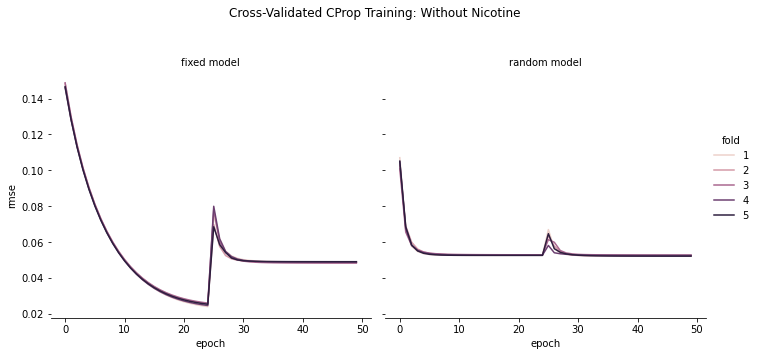

In [38]:
def rmse_cv(rmse_df, title=None):
    # rmse_df = pd.DataFrame(rmse_dict)
    rmse_df = pd.melt(rmse_df, id_vars='model', var_name='fold', value_name='rmse')
    rmse_df['epoch'] = rmse_df.groupby(['model', 'fold']).cumcount()

    g = sns.relplot(
        data=rmse_df,
        x = "epoch",
        y = "rmse",
        hue = "fold",
        col = "model",
        kind = "line"
    )
    # g.set_axis_labels("", "Survival Rate")
    # g.set_xticklabels(["Men", "Women", "Children"])
    g.set_titles("{col_name} {col_var}")
    # g.set(ylim=(0, 1))
    g.despine(left=True)

    g.fig.subplots_adjust(top=0.8)
    g.fig.suptitle(title)

rmse_cv(rmse_nonic, "Cross-Validated CProp Training: Without Nicotine")
plt.savefig("../../reports/figures/counterprop_cv_nonic.png", dpi = 300)


In [39]:
preds_nonic_fixed = counterprp_fit_predict(
    X_train_array,
    X_test_array,
    y_train_onehot,
    y_test_onehot,
    y_test_labels)

preds_nonic_fixed.f1_pred2

0.07766990291262135

In [40]:
preds_nonic_random = counterprp_fit_predict(
    X_train_array,
    X_test_array,
    y_train_onehot,
    y_test_onehot,
    y_test_labels,
    random_init=True)
    
preds_nonic_random.f1_pred2

0.0970873786407767

With Nicotine

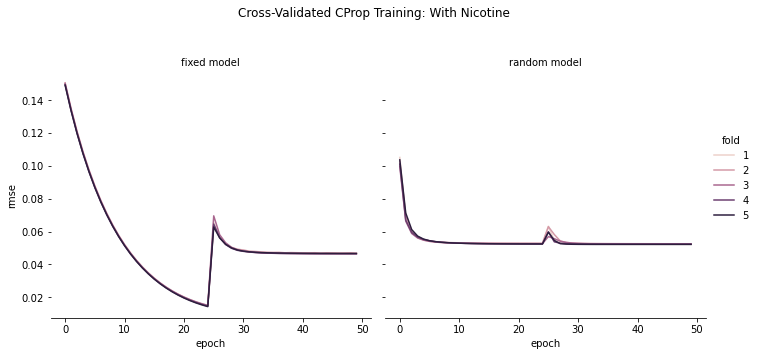

In [41]:
X_train_array = np.array(X_train)
X_test_array = np.array(X_test)

# fixed initialization
cv_fixed_nic = cv_counterprop(X_train_array, y_train_onehot, y_train_labels, model='fixed_w1', random_init=False)

# random initialization
cv_random_nic = cv_counterprop(X_train_array, y_train_onehot, y_train_labels, model='free_w1', random_init=True)

fixed = pd.DataFrame(cv_fixed_nic.rmse_vals)
random = pd.DataFrame(cv_random_nic.rmse_vals)
fixed['model'] = 'fixed'
random['model'] = 'random'

rmse_nic = pd.concat([fixed, random], axis=0)

rmse_cv(rmse_nic, "Cross-Validated CProp Training: With Nicotine")
plt.savefig("../../reports/figures/counterprop_cv_nic.png", dpi = 300)

In [42]:
pd.concat([cv_fixed_nic.metrics_df, cv_random_nic.metrics_df])

,mean_cv_f1,mean_cv_std,model
1,0.046341,0.017923,fixed_w1
1,0.078049,0.048536,free_w1


In [74]:
preds_nic_fixed = counterprp_fit_predict(
    X_train_array,
    X_test_array,
    y_train_onehot,
    y_test_onehot,
    y_test_labels)
preds_nic_fixed.f1_pred2

0.04854368932038835

In [81]:
preds_nic_random = counterprp_fit_predict(
    X_train_array,
    X_test_array,
    y_train_onehot,
    y_test_onehot,
    y_test_labels,
    random_init=True)
preds_nic_random.f1_pred2

0.05825242718446602

Compare Methods 

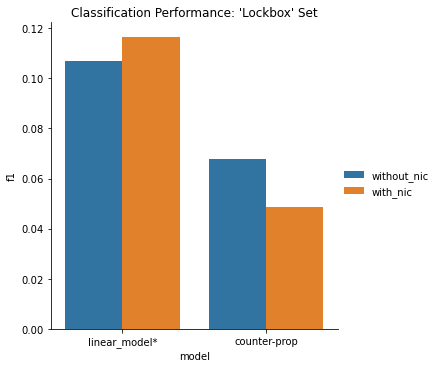

In [75]:
# lm_f1 = pd.DataFrame(
#     {
#         "f1" : [without_nic.clf_mets, with_nic.clf_mets],
#         "label" : ["without_nic", "with_nic"],
#         "model" : ['linear_model*', 'linear_model*']
#     }
# )

cprop_f1 = pd.DataFrame(
    {
        "f1" : [preds_nonic.f1_pred2, preds_nic.f1_pred2],
        "label" : ["without_nic", "with_nic"],
        "model" : ['counter-prop', 'counter-prop']
    }
)

clf_plt(pd.concat([lm_f1, cprop_f1]))
# plt.tight_layout()
plt.savefig(fname = "../../reports/figures/clf_perf_twomtd.png", dpi = 300, bbox_inches='tight')

## Backpropagation

In [1]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

In [7]:
#classification
clf = MLPClassifier(
    random_state=random_state,
    activation='logistic',
    )
clf.fit(X_train, y_train['prp_change_bin_label'])
pred = clf.predict(X_test)
prob = clf.predict_proba(X_test)
f1_with_nic = f1_score(y_test['prp_change_bin_label'], pred, average = 'micro')

In [8]:
clf = MLPClassifier(
    random_state=random_state,
    activation='logistic',
    )
clf.fit(X_train_without_nic, y_train['prp_change_bin_label'])
pred = clf.predict(X_test_without_nic)
print(pred[1])
prob = clf.predict_proba(X_test_without_nic)
f1_without_nic = f1_score(y_test['prp_change_bin_label'], pred, average = 'micro')

10


In [9]:
mlp_f1 = pd.DataFrame(
    {
        "f1" : [f1_without_nic, f1_with_nic],
        "label" : ["without_nic", "with_nic",],
        "model" : ['MLPclassifier', 'MLPclassifier']
    }
)
mlp_f1

,f1,label,model
0,0.126214,with_nic,MLPclassifier*
1,0.116505,without_nic,MLPclassifier*
